# Importing Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly as ply
import plotly.graph_objs as go
import squarify as sq
import seaborn as sns
import math
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
series = pd.read_csv(r"C:\Users\Aryan\Desktop\Data\Time Series\Electric_Production.csv",index_col='DATE',parse_dates=['DATE'])
series.head()

,IPG2211A2N
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


Text(0.5, 1.0, 'The Time Series')

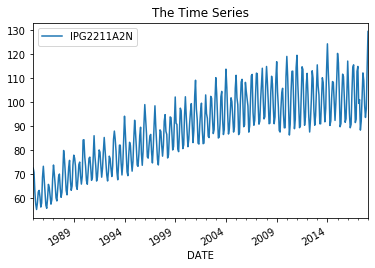

In [3]:
series.plot(subplots=True)
plt.title('The Time Series')

# Some EDA

In [4]:
sns.set()
Series = pd.read_csv(r"C:\Users\Aryan\Desktop\Data\Time Series\Electric_Production.csv")
df = Series

In [5]:
new = df['DATE'].str.split("/",n=3,expand=True)
df['Month'] = new[0]
df['Day'] = new[1]
df['Year'] = new[2]
df = df.drop(['DATE'],axis=1)

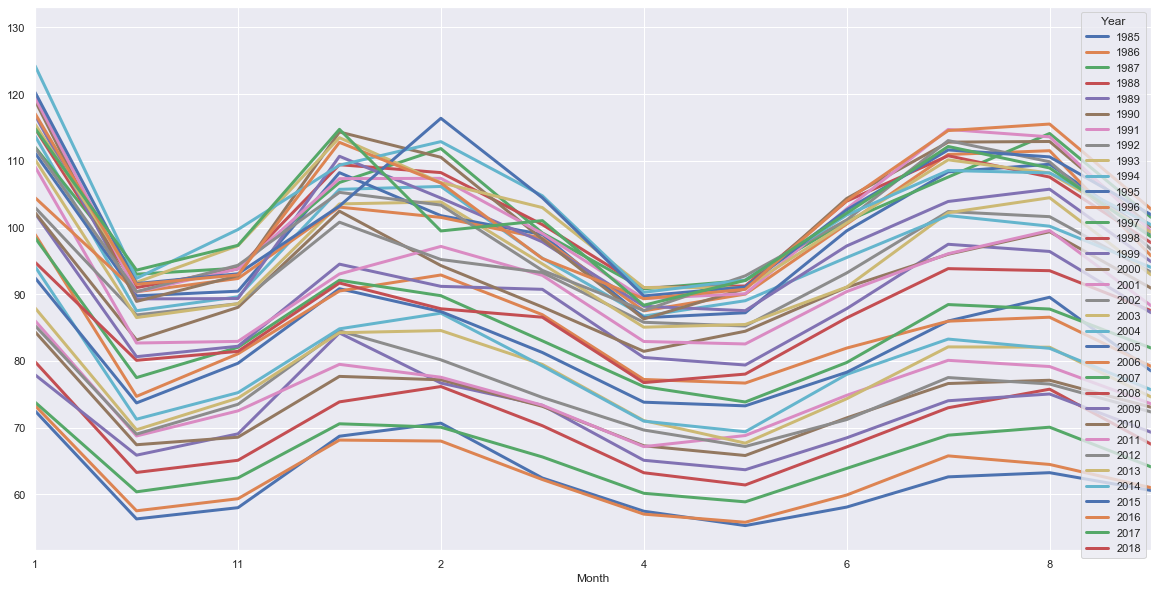

In [6]:
spivot = pd.pivot_table(df, index='Month', columns = 'Year', values = 'IPG2211A2N', aggfunc=np.mean)
spivot.plot(figsize=(20,10), linewidth=3)
plt.show()

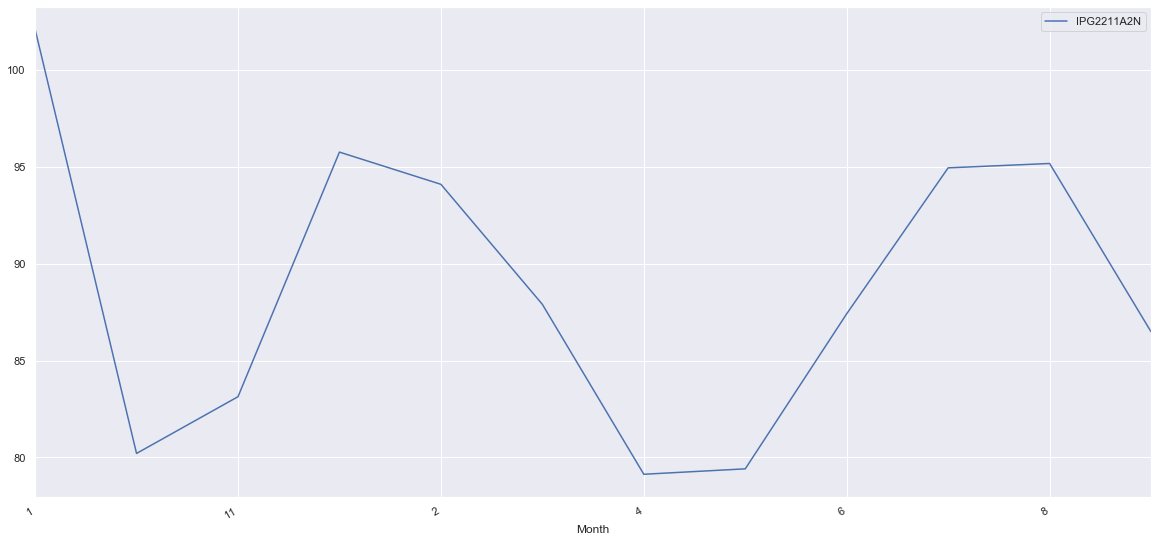

In [7]:
All_month = df.groupby('Month')['Month','IPG2211A2N'].mean().dropna()
All_month.plot(figsize=(20,10),subplots=True)
plt.show()

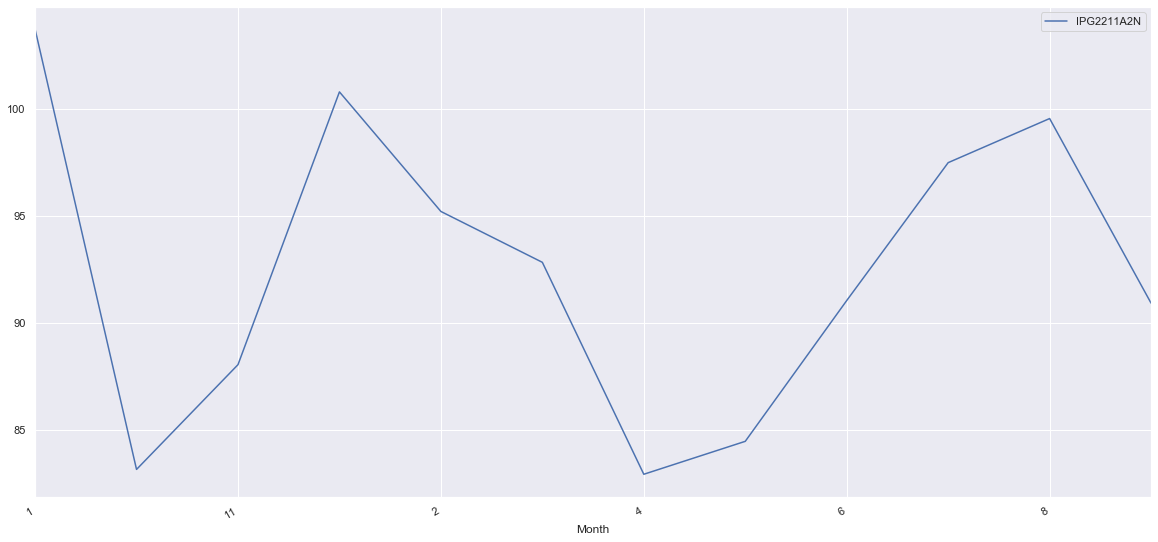

In [8]:
All_month2 = df.groupby('Month')['Month','IPG2211A2N'].median().dropna()
All_month2.plot(figsize=(20,10),subplots=True)
plt.show()

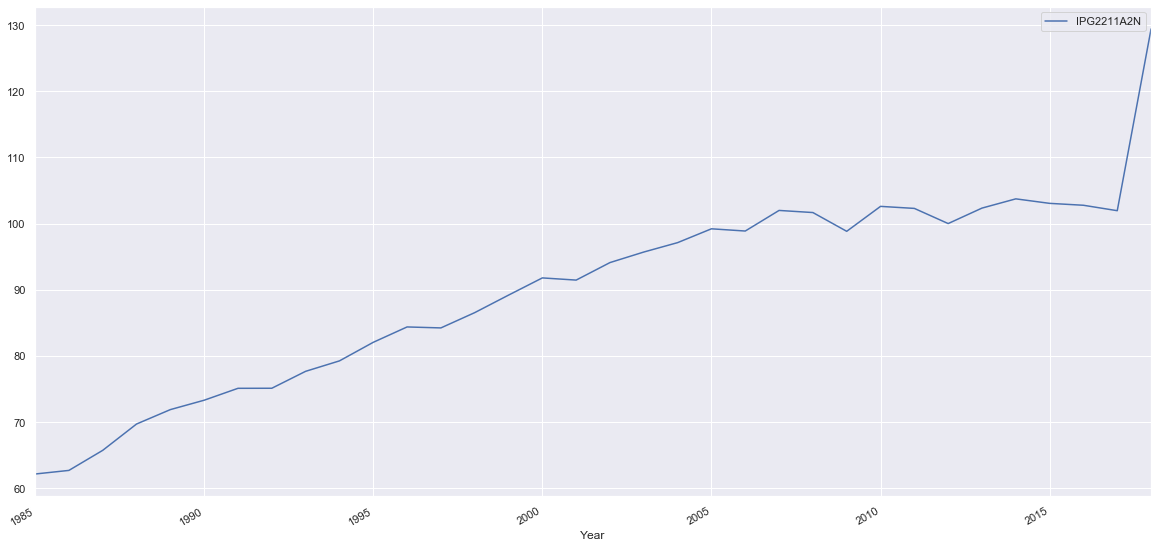

In [9]:
All_year = df.groupby('Year')['Year','IPG2211A2N'].mean().dropna()
All_year.plot(figsize=(20,10),subplots=True)
plt.show()

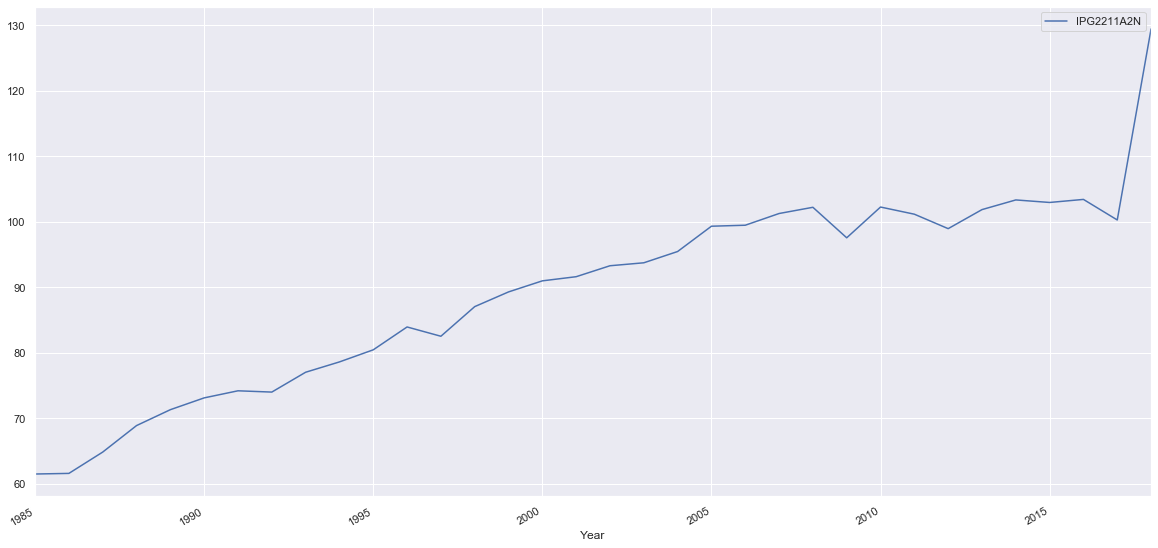

In [10]:
All_year2 = df.groupby('Year')['Year','IPG2211A2N'].median().dropna()
All_year2.plot(figsize=(20,10),subplots=True)
plt.show()

We use LSTM model as this is a regression problem involving the idea of predicting the power demand through power-demads in past years.

In [11]:
Dataframe = pd.read_csv(r"C:\Users\Aryan\Desktop\Data\Time Series\Electric_Production.csv", usecols=[1], engine='python')
S = Dataframe.values
S = S.astype('float32')

In [12]:
s = MinMaxScaler(feature_range=(0,1))
S = s.fit_transform(S)

# Train-Test Splitting of the dataset

In [13]:
train_size = int(len(S) * 0.8)
test_size = len(S) - train_size
train, test = S[0:train_size,:], S[train_size:len(S),:]
print(len(train), len(test))

317 80


Dividing the power-demand column in to two columns such that:-

1) contains last year’s (t) power-demand

2) contains this years’s (t+1) power-demand which has to be predicted

In [14]:
def create_dataset(S, look_back=1):
    dataX, dataY = [], []
    for i in range(len(S)-look_back-1):
        a = S[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(S[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

Look Back is the number of previous time steps to use as input variables to predict the next time period

In [15]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [16]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# Model Training

In [21]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(trainX, trainY, epochs=100, batch_size=2,validation_data=(testX,testY), verbose=2)

Train on 315 samples, validate on 78 samples
Epoch 1/100
 - 4s - loss: 0.1078 - val_loss: 0.1354
Epoch 2/100
 - 1s - loss: 0.0347 - val_loss: 0.0542
Epoch 3/100
 - 1s - loss: 0.0254 - val_loss: 0.0405
Epoch 4/100
 - 1s - loss: 0.0227 - val_loss: 0.0351
Epoch 5/100
 - 1s - loss: 0.0199 - val_loss: 0.0323
Epoch 6/100
 - 1s - loss: 0.0176 - val_loss: 0.0268
Epoch 7/100
 - 1s - loss: 0.0153 - val_loss: 0.0228
Epoch 8/100
 - 1s - loss: 0.0135 - val_loss: 0.0190
Epoch 9/100
 - 1s - loss: 0.0120 - val_loss: 0.0168
Epoch 10/100
 - 1s - loss: 0.0109 - val_loss: 0.0159
Epoch 11/100
 - 1s - loss: 0.0101 - val_loss: 0.0171
Epoch 12/100
 - 1s - loss: 0.0097 - val_loss: 0.0153
Epoch 13/100
 - 1s - loss: 0.0094 - val_loss: 0.0145
Epoch 14/100
 - 1s - loss: 0.0093 - val_loss: 0.0163
Epoch 15/100
 - 1s - loss: 0.0092 - val_loss: 0.0149
Epoch 16/100
 - 1s - loss: 0.0091 - val_loss: 0.0148
Epoch 17/100
 - 1s - loss: 0.0092 - val_loss: 0.0153
Epoch 18/100
 - 1s - loss: 0.0091 - val_loss: 0.0149
Epoch 19/1

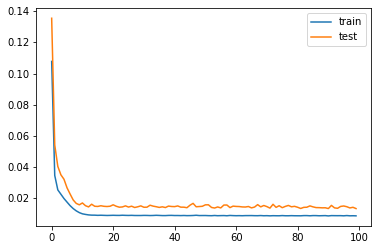

In [22]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# Model Predictions and Accuracy Measures

In [23]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
#Changing prediction to it's original units
trainPredict = s.inverse_transform(trainPredict)
trainY = s.inverse_transform([trainY])
testPredict = s.inverse_transform(testPredict)
testY = s.inverse_transform([testY])

trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score = %.2f MSE' % mean_squared_error(trainY[0],trainPredict[:,0]))
print('Train Score =  %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score = %.2f MSE' % mean_squared_error(testY[0],testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score = 49.12 MSE
Train Score =  7.01 RMSE
Test Score = 73.91 MSE
Test Score: 8.60 RMSE


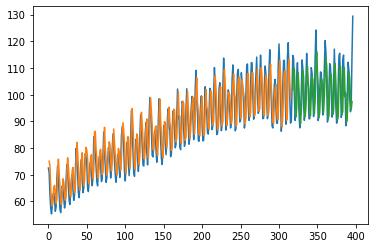

In [24]:
trainPredictPlot = np.empty_like(S)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(S)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(S)-1, :] = testPredict
# plot baseline and predictions
plt.plot(s.inverse_transform(S))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

Color Relations:-

Blue: Orignal Series

Orange: Series generated through Train dataset

Green: Series generated theough Test dataset